In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import GroupKFold , KFold

import os

print_line = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print_line += 1
        if print_line < 5:
            print(os.path.join(dirname, filename))
        else:
            pass
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-effectiveness/sample_submission.csv
/kaggle/input/feedback-prize-effectiveness/train.csv
/kaggle/input/feedback-prize-effectiveness/test.csv
/kaggle/input/feedback-prize-effectiveness/test/D72CB1C11673.txt


In [120]:

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if not iskaggle:
    import zipfile,kaggle
    path = Path('feedback-prize-effectiveness')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [121]:
from fastai.imports import *

In [122]:
if iskaggle: path = Path('../input/feedback-prize-effectiveness')
path.ls()

(#5) [Path('../input/feedback-prize-effectiveness/sample_submission.csv'),Path('../input/feedback-prize-effectiveness/train.csv'),Path('../input/feedback-prize-effectiveness/test.csv'),Path('../input/feedback-prize-effectiveness/test'),Path('../input/feedback-prize-effectiveness/train')]

In [123]:
def reduce_mem_usage(df,verbose=True):
    cols = df.columns.tolist()
    
    numerics = ['int8','int32','int16','int64','float16','float32','float64']
    memory = df.memory_usage().sum() / 1024 ** 2  
    
    
    for col in cols:
        col_type = df[col].dtypes
        if col_type in numerics:
            col_min = df[col].min()
            print(col_min)
            col_max = df[col].max()
            if str(col_type[:3]) == 'int': 
                if col_min > np.iinfo(np.int32).min() and  col_max > np.iinfo(np.int32).max():
                    df[col] =df[col].astype(np.int32)
                if col_min > np.iinfo(np.int64).min() and  col_max > np.iinfo(np.int64).max():
                    df[col] =df[col].astype(np.int64)
                if col_min > np.iinfo(np.int16).min() and  col_max > np.iinfo(np.int16).max():
                    df[col] =df[col].astype(np.int16)
                if col_min > np.iinfo(np.int8).min() and  col_max > np.iinfo(np.int8).max():
                    df[col] =df[col].astype(np.int8)
            else:
                if col_min > np.iinfo(np.float32).min() and  col_max > np.iinfo(np.float32).max():
                    df[col] = df[col].astype(np.float32)
                if col_min > np.iinfo(np.float64).min() and  col_max > np.iinfo(np.float64).max():
                    df[col] = df[col].astype(np.float64) 
    if verbose: print('memory reduce : {}'.format(memory - df.memory_usage().sum() /1024 **2))
    return df

In [124]:

train = pd.read_csv('../input/feedback-prize-effectiveness/train.csv')

In [125]:
test  = pd.read_csv(path/'test.csv')

In [126]:
len(train.discourse_id.unique()) == len(train)

True

In [127]:
train.essay_id.value_counts()

91B1F82B2CF1    23
4CA37D113612    23
900A879708F0    23
A7EC6F462F8B    22
DECAE402BB38    22
                ..
AB02689C1A9B     1
FFFF80B8CC2F     1
377548575048     1
5E85F1FB4E22     1
9706F8E7D534     1
Name: essay_id, Length: 4191, dtype: int64

In [128]:
train.loc[train.essay_id == '91B1F82B2CF1'].head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
25190,2d4def8e7c09,91B1F82B2CF1,Many people may think that attending school online is better than going to school in person. They say that it is better for mental heath and classes can be more advanced or personal for the one student.,Lead,Adequate
25191,0a6634792991,91B1F82B2CF1,"I would say that I disagree with that statement, although on some aspects I do agree.",Position,Adequate
25192,e73c3a854460,91B1F82B2CF1,"Yes, online school would be better for students' mental health now",Counterclaim,Adequate
25193,57d92e1dddb3,91B1F82B2CF1,but what about in the future when they lack basic social skills?,Rebuttal,Adequate
25194,4e57f20c26e0,91B1F82B2CF1,"yes, the online courses could be more personalized to a specific student on some softwares",Counterclaim,Adequate


In [129]:
train['discourse_text']

0                                                                                                                                    Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. 
1                                                                                                                                                                                                                                               On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform 
2                                                                                                 

In [130]:
essay_len = []
for file in os.listdir(path/'train'):
    with open (path/'train'/file) as f:
        essay_len.append(len(f.read()))

In [131]:
min(essay_len) , np.mean(essay_len) , max(essay_len)

(691, 2315.0465282748746, 11641)

(array([1.789e+03, 1.329e+03, 5.840e+02, 3.030e+02, 1.770e+02, 6.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  691.,  1786.,  2881.,  3976.,  5071.,  6166.,  7261.,  8356.,
         9451., 10546., 11641.]),
 <BarContainer object of 10 artists>)

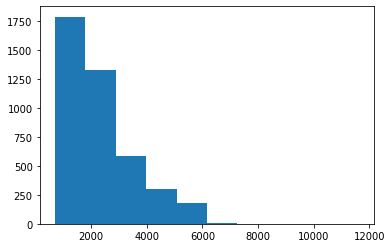

In [132]:
plt.hist(essay_len)

In [133]:
text_len = [len(text) for text in train.discourse_text]

(array([3.0332e+04, 4.9030e+03, 1.1340e+03, 2.7600e+02, 7.6000e+01,
        2.4000e+01, 9.0000e+00, 7.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([4.0000e+00, 4.1350e+02, 8.2300e+02, 1.2325e+03, 1.6420e+03,
        2.0515e+03, 2.4610e+03, 2.8705e+03, 3.2800e+03, 3.6895e+03,
        4.0990e+03]),
 <BarContainer object of 10 artists>)

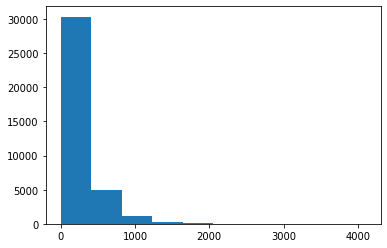

In [134]:
import matplotlib.pyplot as plt
plt.hist(text_len)

In [135]:
train.discourse_type.value_counts()


Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: discourse_type, dtype: int64

In [136]:
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [137]:
if iskaggle:
    !pip install --no-index --find-links ../input/huggingface-datasets datasets -q
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [138]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)


In [139]:
model_nm = '../input/debertav3small'

In [140]:
tokz = AutoTokenizer.from_pretrained(model_nm)

In [141]:
sep = tokz.sep_token

In [142]:
train['inputs'] = train.discourse_type + sep +train.discourse_text

In [143]:
new_label = {"discourse_effectiveness" : {"Ineffective" : 0, "Adequate" : 1, "Effective" :2}}
train = train.replace(new_label)

In [144]:
train.rename(columns = {"discourse_effectiveness" : "label"})

,discourse_id,essay_id,discourse_text,discourse_type,label,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,1,"Position[SEP]On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform"
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,1,Claim[SEP]I think that the face is a natural landform because there is no life on Mars that we have descovered yet
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,1,"Evidence[SEP]If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,1,Counterclaim[SEP]People thought that the face was formed by alieans because they thought that there was life on Mars.
...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking one person for advice because somebody might give better advice than someone else,Claim,1,Claim[SEP]For many people they don't like only asking one person for advice because somebody might give better advice than someone else
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions on things.,Claim,1,Claim[SEP]also people have different views and opinions on things.
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons view in many ways. It can be helpful or harmful depending on what you say.,Position,1,Position[SEP]Advice is something that can impact a persons view in many ways. It can be helpful or harmful depending on what you say.
36763,cc184624ca8e,FFA381E58FC6,"someone can use everything that many people said and use it to help them. Somebody might ask for an opinion of how they look, or what someone thinks of something.\n\nThe person that wants an opinion might want to ask many people because they want to know what is better to do, use, or wear. People always ask for an opinion. Some people do things based on someones' advice because they think it will be better or make the other person happy",Evidence,0,"Evidence[SEP]someone can use everything that many people said and use it to help them. Somebody might ask for an opinion of how they look, or what someone thinks of something.\n\nThe person that 

In [145]:
ds = Dataset.from_pandas(train)

In [146]:
def tok_func(x): return tokz(x["inputs"], truncation = True)

In [147]:
ds[0]['inputs']

"Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. "

In [148]:
inps = "discourse_text" , "discourse_type"

In [149]:
#We can now tokenize the the input. We'll use Dataset.map to speed it up, and remove the columns we no longer need:
tok_ds = ds.map(tok_func, batched=True , remove_columns= inps+('inputs','discourse_id','essay_id'))

  0%|          | 0/37 [00:00<?, ?ba/s]

In [150]:
tok_ds[0].keys()

dict_keys(['discourse_effectiveness', 'input_ids', 'token_type_ids', 'attention_mask'])

In [151]:
essay_ids = train.essay_id.unique()

In [152]:
np.random.seed(42)
np.random.shuffle(essay_ids)

In [153]:
essay_ids[:5]

array(['B5C606F0A883', 'FA4FE7706A1A', '37A77BEAD718', '0ED28D8A5EC4',
       'F25BA634ADDD'], dtype=object)

In [154]:
val_prop = 0.2
val_sz = int(len(essay_ids)*val_prop)
val_essay_ids  = essay_ids[:val_sz]

In [155]:
is_val = np.isin(train.essay_id, val_essay_ids)

In [156]:
idxs = np.arange(len(train))

In [157]:
idxs

array([    0,     1,     2, ..., 36762, 36763, 36764])

In [158]:
val_idxs = idxs[is_val]

In [159]:
trn_idxs  =idxs[~is_val]

In [160]:
val_idxs

array([   53,    54,    55, ..., 36762, 36763, 36764])

In [161]:
len(val_idxs), len(trn_idxs)

(7181, 29584)

In [162]:
tok_ds

Dataset({
    features: ['discourse_effectiveness', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36765
})

In [163]:
dds = DatasetDict({"train" : tok_ds.select(trn_idxs), 
                  "test" : tok_ds.select(val_idxs)})

In [164]:
def get_dds(df, train=True):
    ds = Dataset.from_pandas(df)
    to_remove = ['discourse_text','discourse_type', 'inputs', 'discourse_id','essay_id']
    tok_ds  = ds.map(tok_func , batched=True, remove_columns = to_remove)

    if train:
        return DatasetDict({"train" : tok_ds.select(trn_idxs), "test" : tok_ds.select(val_idxs)})
    else:
        return tok_ds

In [165]:
lr , bs = 8e-5, 16
wd, epochs = 0.01, 1

In [166]:
from sklearn.metrics import log_loss
import torch.nn.functional as F
def score(preds): return {'log_loss' : log_loss(preds.label_ids, F.softmax(torch.Tensor(preds.predictions)))}

In [169]:
def get_trainer(dds):
    args = TrainingArguments('outpus' , learning_rate = lr, warmup_ratio=0.1, 
                    lr_scheduler_type='cosine' , fp16= True ,evaluation_strategy="epoch", per_device_train_batch_size=bs ,
                            per_device_eval_batch_size = bs*2, num_train_epochs = epochs, 
                             weight_decay = wd, report_to ='none')
    model = AutoModleForSequenceClassification.from_pretrained(model_nm,num_labels=3)
    return Trainer(model , args, train_dataset=dds['train'], eval_dataset=dds['test'] ,
                  tokenizer=tokz, compute_metrics=score )

In [179]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
                             #fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=score)

In [ ]:
# fp16=True error


In [181]:
trainer = get_trainer(dds)

ValueError: Mixed precision training with AMP or APEX (`--fp16` or `--bf16`) and half precision evaluation (`--fp16_full_eval` or `--bf16_full_eval`) can only be used on CUDA devices.

In [182]:
trainer.train()

KeyError: 'loss'

In [ ]:
test_df = 1

In [ ]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=score)

In [118]:
get_trainer(dds)

ValueError: Mixed precision training with AMP or APEX (`--fp16` or `--bf16`) and half precision evaluation (`--fp16_full_eval` or `--bf16_full_eval`) can only be used on CUDA devices.

In [ ]:
# 이전대회 솔루션

# https://www.kaggle.com/competitions/feedback-prize-2021/code?competitionId=31779&sortBy=voteCount


In [102]:
#ds[0]['inputs']

"Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. "

In [103]:
#tok_func(ds[0])

{'input_ids': [1, 8380, 2, 2684, 261, 584, 280, 358, 11759, 261, 584, 280, 358, 446, 264, 282, 898, 314, 361, 291, 812, 277, 7583, 269, 266, 1008, 1311, 9930, 289, 337, 343, 269, 432, 277, 7583, 272, 412, 278, 260, 279, 697, 269, 314, 361, 7658, 681, 266, 1355, 265, 7583, 263, 266, 812, 284, 757, 277, 262, 3568, 260, 7658, 702, 280, 297, 391, 337, 262, 1311, 9930, 284, 994, 293, 432, 277, 7583, 261, 289, 337, 278, 269, 348, 266, 1008, 1311, 9930, 260, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

SyntaxError: unexpected EOF while parsing (337305178.py, line 5)